# Burguers'

The Burgers' equation is a fundamental partial differential equation that describes the behavior of fluid flow in one dimension. It is a nonlinear equation known for exhibiting interesting phenomena such as shock waves, rarefaction waves, and the formation of discontinuities in the velocity profile.

The equation can be written as:

$$
∂u/∂t + u ∂u/∂x = ν ∂^2u/∂x^2
$$

where u represents the velocity of the fluid, t is time, x is the spatial coordinate, and ν is the kinematic viscosity coefficient.

In this example, the dataset used was downloaded from [PDEBench](https://github.com/pdebench/PDEBench). The dataset corresponds to a case with constant viscosity (ν), periodic boundary conditions, and an initial condition given by:

$$
u_0(x) = \sum_{ki =k_1 ,...,k_N} A_i sin(k_i x + φi)
$$


This equation represents a sum of sinusoidal functions with different amplitudes (A_i), wave numbers (k_i), and phase shifts (φ_i).

To demonstrate the robustness of the weak approach, noise was added to the original dataset. This allows for testing the effectiveness of the method in the presence of noise.

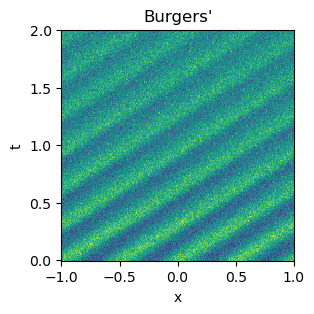

In [6]:
import pickle
import matplotlib.pyplot as plt

with open('burgers_data', 'rb') as handle:
    burgers_data = pickle.load(handle)

data = burgers_data['data']
x = burgers_data['x']
time = np.linspace(0,2,201)

from sklearn.metrics import mean_squared_error

def add_noise(data, noise_level=0.0):
    rmse = mean_squared_error(data, np.zeros((data).shape), squared=False)
    return data + np.random.normal(0, rmse * noise_level , data.shape) 

gtdata = np.copy(data)
data = add_noise(data, noise_level=0.03)

plt.figure(figsize=(3,3))
plt.pcolormesh(x, time, data)
plt.title("Burgers'")
plt.ylabel('t')
plt.xlabel('x')
plt.show()

# Order Reduction

The PDE was solved using finite difference method using a spatial discretization with $1024$ points. In order to make the training feasible, and order reduction was performed using POD targeting to preserve at leas 99% of modal energy.

In [38]:
from simulai.rom import POD
from simulai.io import Reshaper
from simulai.simulation import Pipeline

class orderReduction:
    def __init__(self, rom_config: dict = {} ) -> None:
        self.rom_config = rom_config
        self.input_data = self.rom_config['input_data']
        self.stages = self.rom_config['stages']

        self.pipeline = Pipeline(self.stages)
        self.pipeline.exec(self.input_data)

    def project_data(self, data=None):
        if data is None:
            data = self.input_data
        elif len(data.shape) == 1:
            data = data[None,:]
        return self.pipeline.project_data(data=data)

    def reconstruct_data(self, data=None):
        if data is None:
            data = self.projected_data
        elif len(data.shape) == 1:
            data = data[None,:]
        return self.pipeline.reconstruct_data(data=data)
    
pod_config = {
    'n_components' : 4
}

rom_config = {
    'stages' : [ ('data_preparer', Reshaper()),
                 ('rom', POD(config=pod_config)) ],
    'input_data' :  gtdata,
}

rom = orderReduction(rom_config)
pdata = rom.project_data(data)

Executing a global pipeline.
Executed operation RESHAPER.
Relative contribution of the mean component: 0.07053456455469131
Relative Modal Energy 0.9971914887428284
Executed operation POD.


Since the dataset has limite number os timesteps (201), we chose to only split data into a training and a test portion.

In [39]:
import sys
import pathlib
sys.path.append(str(pathlib.Path('/Users/properallan/Documents/github/simulai').resolve()))
from examples.utils.slice_data import sliceDataAlongAxis


gtdata_train, gtdata_test = sliceDataAlongAxis(data=gtdata, fractions=[0.5,0.5], axis=0)
data_train, data_test = sliceDataAlongAxis(data=data, fractions=[0.5,0.5], axis=0)
pdata_train, pdata_test = sliceDataAlongAxis(data=pdata, fractions=[0.5,0.5], axis=0)
time_train, time_test = sliceDataAlongAxis(data=time, fractions=[0.5,0.5], axis=0)

# WeakOpInf

The Operator Inference (OpInf) method is a data-driven approach used for modeling and prediction of dynamical systems. It aims to learn a reduced-order model of a system directly from data, without relying on explicit knowledge of the underlying governing equations, [(MCQUARRIE, HUANG, and WILLCOX,  2021)](https://arxiv.org/abs/2008.02862). The system dynamics is represented as combination of constant ($\mathbf c$), linear($\mathbf A$), quadratic-nonlinear ($\mathbf H$) and forcin($\mathbf B$) terms.

$$
\frac{d}{dt}x(t) = \mathbf c + \mathbf Ax(t) + \mathbf H(x(t) ⊗ x(t)) + \mathbf Bu(t)
$$

Oposed to SINDy, basis functions are not needed anymore, since non-linearities are assumed to be quadratic and are represented by the Kronecher product of state variable $x(t)$. In a similar way we did with SINDy, we propose to identify the weak version of the aforementioned equation by introduction test functions $\psi$. For compactly suported test functions, we have 

$$
\begin{aligned}
- \langle x, \dot{\psi}_k \rangle =  \mathbf c \langle 1, \psi_k \rangle + \mathbf A \langle x, \psi_k \rangle +   \mathbf H \langle (x \otimes x), \psi_k \rangle + \mathbf B \langle u, \psi_k \rangle
\end{aligned}
$$

The system indentification is then reducet to find the weigths

$$
\begin{aligned}
&\min_\mathbf{w}\| \mathbf{G}\mathbf{w} - \mathbf{b} \|^2_2 + \lambda R(\mathbf{w})
\end{aligned}
$$

, with 

$$
\begin{aligned}
\mathbf{b} &= - \langle x, \dot{\psi}_k \rangle \\
\mathbf{G} &= [ \quad \langle c, \psi_k \rangle \quad \langle x, \psi_k \rangle \quad \langle (x \otimes x), \psi_k \rangle \quad \langle u, \psi_k \rangle  \quad ] \\
\mathbf{w} &= [ \quad \mathbf{c} \quad \mathbf{A} \quad \mathbf{H} \quad \mathbf{B} \quad ]
\end{aligned}
$$

For the weak OpInf, only `UniformTestFunction` where implemented by now

In [40]:
from simulai.math.basis import UniformTestFunction
from simulai.regression import WeakOpInf

test_function = UniformTestFunction(p=16, q=16, L=10, overlap=0.5, ghost_cells=0)

wopinf = WeakOpInf(
    bias_rescale=1e-15, 
    solver='lstsq', 
    test_function=test_function)

wopinf.fit(input_data=pdata_train, target_data=time_train)


Forcing terms are not being used.
Solving linear system ...
Fitting process concluded.


In [41]:
from simulai.math.integration import ClassWrapper, BRKF78

right_operator = ClassWrapper(wopinf)

solver = BRKF78(right_operator)

wopinf_predicted = solver.run(initial_state=pdata_test[0], t=time_test)

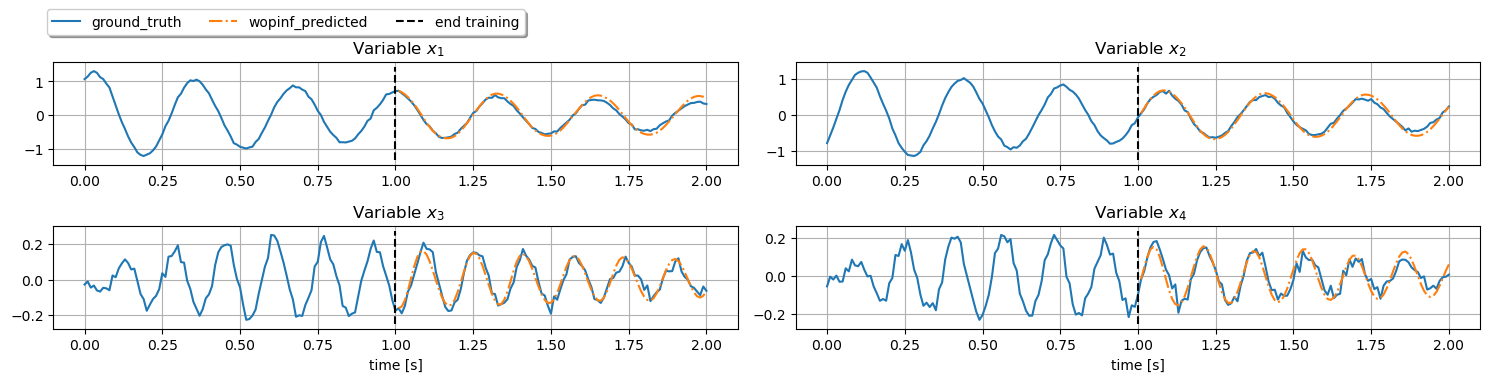

In [42]:
from examples.utils.plot import plot_latent

fig, ax = plot_latent(
            [ (time, pdata),
              (time_test, wopinf_predicted)], 
            [ dict(label='ground_truth', ls='-'),
              dict(label='wopinf_predicted', ls='-.') ],
            vlines=[ time_train[-1] ],
            vlines_kwargs = [ dict(label='end training', color='k', ls='--') ],
            label_ncol=3,
            xlabel='time [s]', )


In [43]:
from simulai.metrics import L2Norm, PointwiseError
perror = PointwiseError()

wopinf_reconstructed = rom.reconstruct_data(data=wopinf_predicted)
error = perror(data=wopinf_reconstructed, reference_data=data_test)

Applying the global reconstruction strategy.


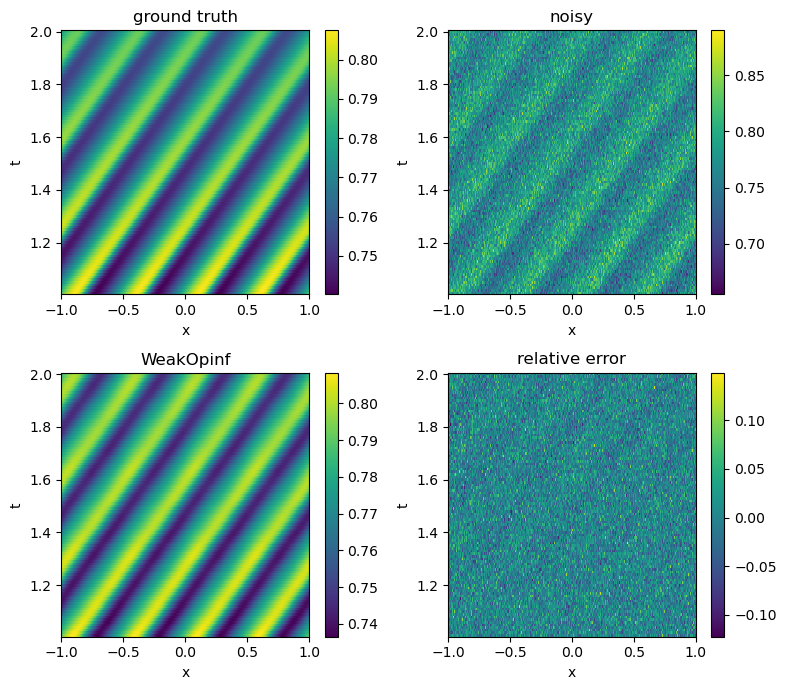

In [44]:
fig, ax = plt.subplots(2, 2, figsize=(8,7))
datas = [gtdata_test, data_test, wopinf_reconstructed, error]
title = ['ground truth', 'noisy', 'WeakOpinf', 'relative error']

vmin = np.min(data[0])
vmax = np.max(data[0])
for i, axi in enumerate(ax.flatten()):
    pc = axi.pcolormesh(hf['x'], time_test, datas[i])
    axi.set_title(title[i])
    axi.set_ylabel('t')
    axi.set_xlabel('x')
    cbar = plt.colorbar(pc)

plt.tight_layout()